In [15]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import functions as f
%matplotlib inline
filename     = 'DQ Tau.tbl'
system       = np.genfromtxt(filename, skip_header=1, usecols=(0, 1, 2))
JD, RVp, RVs = [datum[0] for datum in system], [datum[1] for datum in system], [datum[2] for datum in system]
JDp, JDs     = JD, JD

periodogram = f.periodogram
dataWindow  = f.dataWindow
maxima      = f.maxima
phases      = f.phases
massRatio   = f.massRatio
adjustment  = f.adjustment
RV          = f.RV

for i in range(0, len(JD)-1):
    if np.isnan(system[i][1]):
        JDp, RVp = adjustment(JD, RVp)
        break
        
for i in range(0, len(JD)-1):
    if np.isnan(system[i][2]):
        JDs, RVs = adjustment(JD, RVs)
        break

mass_ratio = 0.898896068135
Period = 15.8045

#this function is a slighty tweaked version of the plotter function, designed to play nicely with
#scipy's curvefit function
def alteredRV(x, K, e, w, T, P, y): #function generates RV values plot from given parameters
    M = (2*np.pi/P)*(x-T) #Mean Anomaly is a function of time
    E1 = M + e*np.sin(M) + ((e**2)*np.sin(2*M)/2) #Eccentric Anomaly is a function of Mean Anomaly
    while True: #iteratively refines estimate of E1 from initial estimate
        E0 = E1
        M0 = E0 - e*np.sin(E0)
        E1 = E0 +(M-M0)/(1-e*np.cos(E0))
        if np.amax(E1-E0) < 1E-9:
            break
    nu = 2*np.arctan(np.sqrt((1 + e)/(1 - e))*np.tan(E1/2)) #True Anomaly is a function of Eccentric anomaly
    p = ((K)*(np.cos(nu+w) + (e*np.cos(w)))+y)#, ((-K/mass_ratio)*(np.cos(nu+w) + (e*np.cos(w)))+y)
    return p#, s 

parameters, cov = curve_fit(alteredRV, JDp, np.asarray(RVp),
                            bounds=([0, 0, 0, 0, 15, 10], [200, 0.9, 2*np.pi, JDp[-1], 16.6, 35]))
print(parameters)

[  2.12061365e+01   5.76422768e-01   4.05944228e+00   2.83304833e+04
   1.58009050e+01   2.36795057e+01]


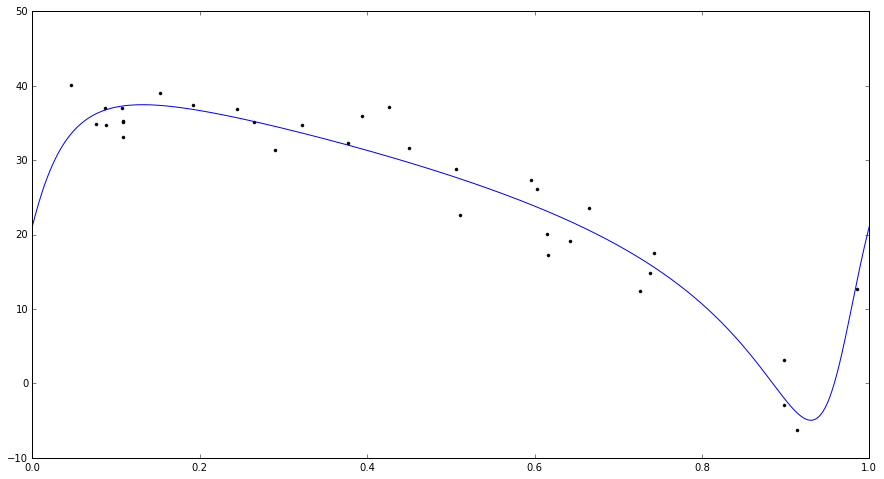

In [16]:
x = np.linspace(0, parameters[4], num=1000)

primary, secondary = RV(x, mass_ratio, parameters)
plt.figure(figsize=(15,8))
plt.plot(phases(parameters[4], 0, JDp), np.asarray(RVp), 'k.')
#plt.plot(phases(parameters[4], 0, JDs), RVs, 'r.')
plt.plot(x/parameters[4], primary)
#plt.plot(x/parameters[4], secondary, 'm')
#plt.plot(x/parameters[4], y*np.ones(len(x)), 'k')
#plt.savefig('fit.png')

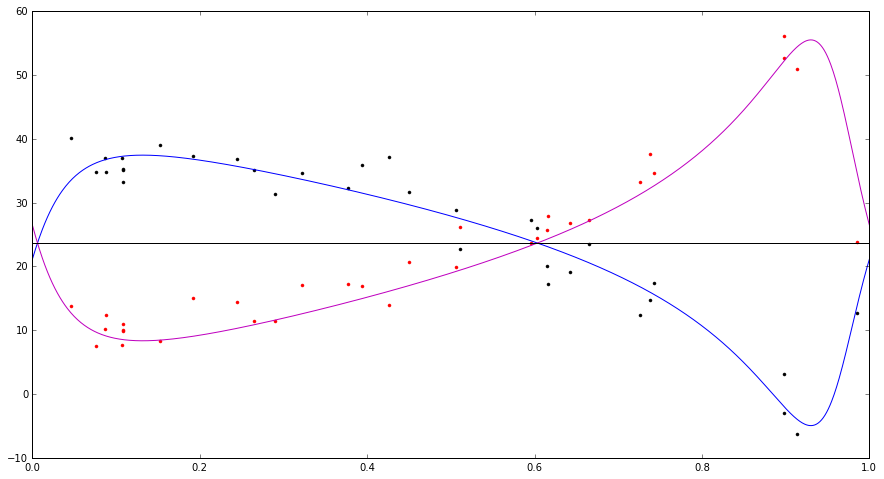

In [17]:
plt.figure(figsize=(15,8))
plt.plot(phases(parameters[4], 0, JDp), RVp, 'k.')
plt.plot(phases(parameters[4], 0, JDs), RVs, 'r.')
plt.plot(x/parameters[4], primary)
plt.plot(x/parameters[4], secondary, 'm')
plt.plot(x/parameters[4], parameters[5]*np.ones(len(x)), 'k')
#plt.savefig('fit.png')

In [18]:
def residuals(JDp, JDs, mass_ratio, primary, secondary, parameters):
    r = np.sqrt(sum((np.asarray(primary)-RV(JDp, mass_ratio, parameters)[0])**2)
        +sum((np.asarray(secondary)-RV(JDs, mass_ratio, parameters)[1])**2))
    return r

print(residuals(mass_ratio, RVp, RVs, parameters))

26.4488895712


In [ ]:
minimized_fit = minimize(residuals, parameters, args=(mass_ratio, primary, secondary),
                         bounds=((0,200),(0,0.9),(0,2*np.pi),(0,JDp[-1]),(15,16.6),(10,35)))
print(minimized_fit)

In [ ]:
print(JDp[-1])